## Imports

In [24]:
import os.path as osp
import random
from itertools import product

import numpy as np
from sklearn.linear_model import LogisticRegression

import torch
import torch.nn.functional as F

import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid, RandomPartitionGraphDataset
from torch_geometric.nn import (
    GCNConv, GATv2Conv, GATConv, SAGEConv, GINConv, TransformerConv
)

import matplotlib.pyplot as plt

## Creating Models

In [105]:
# global variables
homophily_ratios = [round(0.1*x, 1) for x in range(1, 10)]
models = {}
epoch_train_lists = {}
epoch_val_lists = {}
epoch_test_lists = {}

# hyperparameters
args = {"num_datasets_per_ratio": 3,
        "num_nodes_per_class": 500,
        "average_degree": 4,
        "epochs": 200,
        "lr": 0.001,
        "weight_decay": 5e-4,
        "hidden_channels": 128,
        "layer": "GCNConv",  # GCNConv, SAGEConv, GATConv, GATv2Conv, TransformerConv
        "bias": True, 
        }

### Dataset Generation

In [101]:
# Fetching the cora dataset to get its features
path_real = osp.join("/mnt/nas2/GNN-DATA/PYG", Planetoid.__name__)
dataset_real = Planetoid(path_real, "Cora")
data_real = dataset_real[0]

path_syn = osp.join("/mnt/nas2/GNN-DATA/PYG", RandomPartitionGraphDataset.__name__)

################################# Dataset generation ###########################


def generate_datasets(K, average_degree, num_nodes_per_class, homophily_ratios):
    datasets = {}

    for node_homophily_ratio in homophily_ratios:
        data_syn_list = []
        for i in range(K):
            dataset_syn = RandomPartitionGraphDataset(
                path_syn,
                num_channels=dataset_real.num_features,
                num_classes=dataset_real.num_classes,
                num_nodes_per_class=num_nodes_per_class,
                node_homophily_ratio=node_homophily_ratio,
                average_degree=average_degree,
                # **kws,  # node_homophily_ratio=0.63, average_degree=3.90,
                transform=T.Compose([
                    T.RandomNodeSplit("random", num_splits=K),
                ]),
            )
            data_syn = dataset_syn[0]
            data_syn_list.append(data_syn)
        datasets[node_homophily_ratio] = data_syn_list
    
    return datasets

In [102]:
datasets = generate_datasets(args["num_datasets_per_ratio"], args["average_degree"], args["num_nodes_per_class"], homophily_ratios)

Processing...
Done!
Processing...
Done!
Processing...
Done!
Processing...
Done!
Processing...
Done!
Processing...
Done!
Processing...
Done!
Processing...
Done!
Processing...
Done!


### Model Definition

In [103]:
class Net(torch.nn.Module):
    def __init__(self, args, bias=True):
        super().__init__()
        self.args = args

        hidden_channels=self.args["hidden_channels"]
        layer = self.args["layer"]
        _cls = eval(layer)
        if layer == "GCNConv" or layer == "SAGEConv":
            self.conv1 = _cls(dataset_real.num_features, hidden_channels, bias=bias)
            self.conv2 = _cls(hidden_channels, dataset_real.num_classes)
        elif layer == "GATConv" or layer == "TransformerConv" or layer == "GATv2Conv":
            self.conv1 = _cls(dataset_real.num_features, hidden_channels // 8, heads=8, bias=bias)
            self.conv2 = _cls(hidden_channels, dataset_real.num_classes, bias=bias)
        else:
            raise ValueError(f"Wrong layer: {layer}")
        
        self.optimizer = torch.optim.Adam(self.parameters(), lr=self.args["lr"], weight_decay=self.args["weight_decay"])
        

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        conv_layer_1 = self.conv1(x, edge_index, edge_attr)
        relu_layer = F.elu(conv_layer_1)
        drop_out_layer = F.dropout(relu_layer)
        conv_layer_2 = self.conv2(drop_out_layer, edge_index, edge_attr)
        return F.log_softmax(conv_layer_2, dim=1)

    def embed(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        return self.conv1(x, edge_index, edge_attr)

    def train_model(self, data, idx=None):
        self.train()

        if data.train_mask.dim() >= 2 and idx is not None:
            mask = data.train_mask[:, idx]
        else:
            mask = data.train_mask
        (F.nll_loss(self(data)[mask], data.y[mask]) / self.args["num_datasets_per_ratio"]).backward()

        if idx is None or idx == self.args["num_datasets_per_ratio"] - 1:
            self.optimizer.step()
            self.optimizer.zero_grad()


    @torch.no_grad()
    def test(self, data, idx=None):
        self.eval()
        log_probs, accs = self(data), []
        for _, mask in data("train_mask", "val_mask", "test_mask"):

            if mask.dim() >= 2 and idx is not None:
                mask = mask[:, idx]

            pred = log_probs[mask].max(1)[1]
            acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
            accs.append(acc)
        return accs


    @torch.no_grad()
    def logistic_regression_test(self, data, h_type):
        reg = LogisticRegression()
        self.eval()
        if h_type == "x":
            h = data.x.cpu()
        elif h_type == "h1":
            h = self.embed(data).cpu()
        elif h_type == "h2":
            h = self(data_real).cpu()
        else:
            raise ValueError(f"Wrong type: {h_type}")

        y = data.y.cpu()
        reg.fit(h[data.train_mask].numpy(),
                y[data.train_mask].numpy())
        lr_test_acc = reg.score(h[data.test_mask].numpy(),
                                y[data.test_mask].numpy())
        return lr_test_acc

    def fit(self, data_syn_list, verbose=True):
        epoch_train_list, epoch_val_list, epoch_test_list = [], [], []

        for epoch in range(self.args["epochs"]):
            random.shuffle(data_syn_list)

            train_list, val_list, test_list = [], [], []
            
            for data_syn in data_syn_list:
                self.train_model(data_syn, idx=epoch % self.args["num_datasets_per_ratio"])
                train_acc, val_acc, test_acc = self.test(data_syn, idx=epoch % self.args["num_datasets_per_ratio"])
                train_list.append(train_acc)
                val_list.append(val_acc)
                test_list.append(test_acc)

            epoch_train_list.append(np.mean(train_list)) # per epoch, avg train acc
            epoch_val_list.append(np.mean(val_list)) # per epoch, avg val acc
            epoch_test_list.append(np.mean(test_list)) # per epoch, avg test acc

            if epoch % 10 == 0 and verbose:
                print(
                    f"{self.args['layer']} | "
                    f"Epoch: {epoch:03d}, "
                    f"Train: {np.mean(train_list):.4f}, "
                    f"Val: {np.mean(val_list):.4f}, "
                    f"Test: {np.mean(test_list):.4f}, "
                    f'LRT X: {self.logistic_regression_test(data_real, "x"):.4f}, '
                    f'LRT H1: {self.logistic_regression_test(data_real, "h1"):.4f}, '
                    f'LRT H2: {self.logistic_regression_test(data_real, "h2"):.4f}'
                )

        return epoch_train_list, epoch_val_list, epoch_test_list
        

### Model Training and Evalutions

In [55]:
def training_plot(train_accuracy, validation_accuracy, homophily_ratio):
    """Saves a plot of the training and validation loss curves."""
    plt.figure()
    plt.plot(range(len(train_accuracy)), train_accuracy)
    plt.plot(range(len(validation_accuracy)), validation_accuracy)
    plt.xlabel("Epochs", fontsize=16)
    plt.ylabel("Accuracy", fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.tight_layout()
    plt.savefig(f"./training_plots/h_{homophily_ratio}_epoch_accuracy.png")

In [104]:
for ratio in homophily_ratios:
    print("======= Starting training for homophily =", ratio, "===============")
    model = Net(args)
    epoch_train_list, epoch_val_list, epoch_test_list = model.fit(data_syn_list=datasets[ratio])
    models[ratio] = model
    epoch_train_lists[ratio], epoch_val_lists[ratio], epoch_test_lists[ratio] = epoch_train_list, epoch_val_list, epoch_test_list
    print("======= Ended training for homophily =", ratio, "===============")

======= Starting training for homophily = 0.1 ===============
GCNConv | Epoch: 000, Train: 0.1548, Val: 0.1300, Test: 0.1490, LRT X: 0.5750, LRT H1: 0.6680, LRT H2: 0.2650
GCNConv | Epoch: 010, Train: 0.3976, Val: 0.2133, Test: 0.2163, LRT X: 0.5750, LRT H1: 0.6710, LRT H2: 0.2470
GCNConv | Epoch: 020, Train: 0.6786, Val: 0.2940, Test: 0.2690, LRT X: 0.5750, LRT H1: 0.6640, LRT H2: 0.2290
GCNConv | Epoch: 030, Train: 0.7762, Val: 0.3047, Test: 0.3127, LRT X: 0.5750, LRT H1: 0.6630, LRT H2: 0.2640
GCNConv | Epoch: 040, Train: 0.8286, Val: 0.3380, Test: 0.3383, LRT X: 0.5750, LRT H1: 0.6590, LRT H2: 0.2470
GCNConv | Epoch: 050, Train: 0.9119, Val: 0.3440, Test: 0.3497, LRT X: 0.5750, LRT H1: 0.6530, LRT H2: 0.2700
GCNConv | Epoch: 060, Train: 0.9143, Val: 0.3620, Test: 0.3483, LRT X: 0.5750, LRT H1: 0.6590, LRT H2: 0.2980
GCNConv | Epoch: 070, Train: 0.9405, Val: 0.3767, Test: 0.3483, LRT X: 0.5750, LRT H1: 0.6600, LRT H2: 0.2500
GCNConv | Epoch: 080, Train: 0.9619, Val: 0.3593, Test: 0.

In [65]:
GAT_results_300epoch = {
    "models": models,
    "epoch_train_lists": epoch_train_lists,
    "epoch_val_lists": epoch_val_lists,
    "epoch_test_lists": epoch_test_lists,
    "args": args
}

In [106]:
GCN_vboy = {
    "models": models,
    "epoch_train_lists": epoch_train_lists,
    "epoch_val_lists": epoch_val_lists,
    "epoch_test_lists": epoch_test_lists,
    "args": args
}

In [110]:
import pickle
with open("./results/GCN_vboy", "wb") as outfile:
    pickle.dump(GCN_vboy, outfile)

0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9


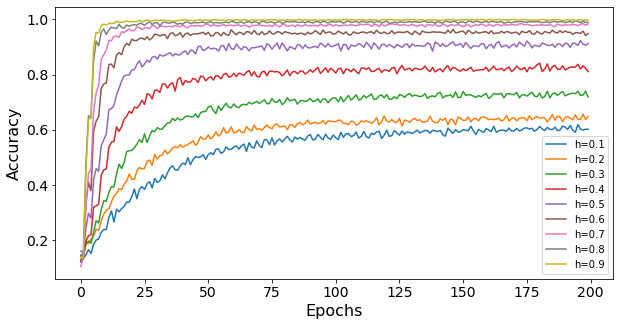

In [96]:
plt.figure(figsize=(10, 5))
for ratio in homophily_ratios:
  print(ratio)
  train_accuracy = epoch_train_lists[ratio]
  validation_accuracy = epoch_val_lists[ratio]
  # plt.plot(range(len(train_accuracy)), train_accuracy)
  plt.plot(range(len(validation_accuracy)), validation_accuracy, label=f"h={ratio}")
  plt.legend()

plt.xlabel("Epochs", fontsize=16)
plt.ylabel("Accuracy", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend()
# plt.tight_layout()
plt.savefig(f"./training_plots/epoch_val_accuracies_GAT300.png")

In [83]:
ratio = 0.4
print("======= Starting training for homophily =", ratio, "===============")
model = Net(args)
epoch_train_list, epoch_val_list, epoch_test_list = model.fit(data_syn_list=datasets[ratio])
models[ratio] = model
epoch_train_lists[ratio], epoch_val_lists[ratio], epoch_test_lists[ratio] = epoch_train_list, epoch_val_list, epoch_test_list
print("======= Ended training for homophily =", ratio, "===============")

======= Starting training for homophily = 0.4 ===============
SAGEConv | Epoch: 000, Train: 0.1500, Val: 0.1300, Test: 0.1491, LRT X: 0.5750, LRT H1: 0.4960, LRT H2: 0.1580
SAGEConv | Epoch: 010, Train: 0.9262, Val: 0.6540, Test: 0.6355, LRT X: 0.5750, LRT H1: 0.4640, LRT H2: 0.2420
SAGEConv | Epoch: 020, Train: 0.9738, Val: 0.6940, Test: 0.7035, LRT X: 0.5750, LRT H1: 0.4640, LRT H2: 0.2360
SAGEConv | Epoch: 030, Train: 0.9786, Val: 0.7300, Test: 0.7132, LRT X: 0.5750, LRT H1: 0.4720, LRT H2: 0.2540
SAGEConv | Epoch: 040, Train: 0.9881, Val: 0.7260, Test: 0.7175, LRT X: 0.5750, LRT H1: 0.4690, LRT H2: 0.2460
SAGEConv | Epoch: 050, Train: 0.9857, Val: 0.7240, Test: 0.7425, LRT X: 0.5750, LRT H1: 0.4660, LRT H2: 0.2710
SAGEConv | Epoch: 060, Train: 0.9929, Val: 0.7420, Test: 0.7311, LRT X: 0.5750, LRT H1: 0.4670, LRT H2: 0.2680
SAGEConv | Epoch: 070, Train: 0.9905, Val: 0.7467, Test: 0.7382, LRT X: 0.5750, LRT H1: 0.4660, LRT H2: 0.2560
SAGEConv | Epoch: 080, Train: 0.9905, Val: 0.7427,

KeyboardInterrupt: 

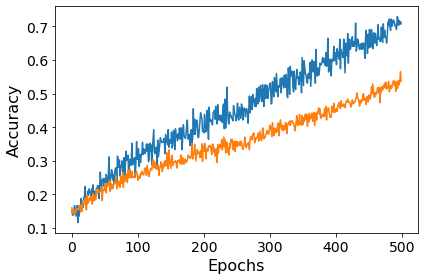

In [74]:
training_plot(epoch_train_list, epoch_val_list, 0.4)